In [55]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [56]:
T = 0.005
s = ctl.TransferFunction.s

In [57]:
G = 0.025/(0.15560577*s**2 - 0.78893795*s + 1.0)
C = (1.04724542759888*s**4 + 112.536831018521*s**3 + 797.097868870119*s**2 + 1595.5905893198*s + 868.628863946332)/(3.9424e-5*s**4 + 0.0411796023500957*s**3 + 1.77365923504158*s**2 + 18.0568849459*s)

G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([2.61811357e-02, 2.81342078e+00, 1.99274467e+01, 3.98897647e+01,
       2.17157216e+01]), array([6.13460188e-06, 6.37668064e-03, 2.69724020e-01, 4.26504878e+00,
       7.45534416e+00, 5.79466497e+01, 2.17157216e+01]))

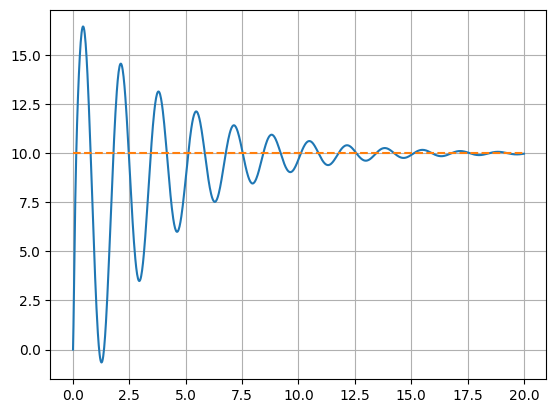

In [58]:
sp = 10

tData = np.linspace(0, 20, 1000)
uData = [sp for i in tData]
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)

plt.plot(time, response)
plt.plot(time, [sp for i in time], '--')
plt.grid()

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [59]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([2.02533155e-06, 2.04251849e-06]), array([ 1.        , -2.02551188,  1.02567459]), 0.005)

In [60]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([  8674.31940462, -30906.72533512,  40805.8282426 , -23587.4537277 ,
         5014.03494683]), array([ 1.        , -2.36131468,  1.39438364,  0.30985804, -0.34292701]), 0.005)

In [61]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([ 0.01756837, -0.04487891,  0.01951777,  0.03557424, -0.03802273,
        0.01024126]), array([ 1.        , -4.36925818,  7.15805026, -4.9169053 ,  0.49520998,
        0.97439351, -0.34149026]), 0.005)

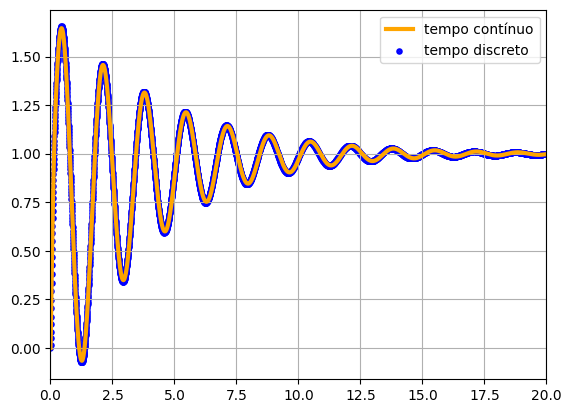

In [62]:
time, response = ctl.step_response(G_feedback)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

time, response = ctl.step_response(G_z_feedback)
plt.scatter(time, response, color='blue', linewidth=3, label='tempo discreto', s=3)

plt.xlim([0, 20])
plt.legend()
plt.grid()
plt.show()

# COMPARANDO A RESPOSTA DO CONTROLADOR

- Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada

In [63]:
num, den = ctl.tfdata(C_z)
num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

print(num)
print(den)

[  8674.31940462 -30906.72533512  40805.8282426  -23587.4537277
   5014.03494683]
[ 1.         -2.36131468  1.39438364  0.30985804 -0.34292701]


- Printando a saída de forma a ser entendida por uma máquina de baixo nível

In [64]:
out = ''

for i in range(0, len(num)):
    out += f'{num[i]}*X_n{i} + '

for i in range(1, len(den)):
    out += f'+ {-1*den[i]}*Y_n{i}'

out = out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')
print(out + ';')

8674.319404615486*X_n -30906.725335115705*X_n1 + 40805.828242597854*X_n2 -23587.453727697422*X_n3 + 5014.034946829281*X_n4 + 2.361314675453079*Y_n1-1.3943836448798095*Y_n2-0.30985803657698224*Y_n3+ 0.3429270060037129*Y_n4;


- Resposta do controlador em feedback

In [65]:
Y_n1 = Y_n2 = Y_n3 = Y_n4 = 0
X_n1 = X_n2 = X_n3 = X_n4 = 0

def computeController(inputValue, setpoint):
    global Y_n1, Y_n2, Y_n3, Y_n4
    global X_n1, X_n2, X_n3, X_n4

    X_n =  setpoint - inputValue
    Y_n = eval(out)

    X_n4 = X_n3
    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n4 = Y_n3
    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

- Comparando os dados contínuo e digital de forma gráfica através de um step

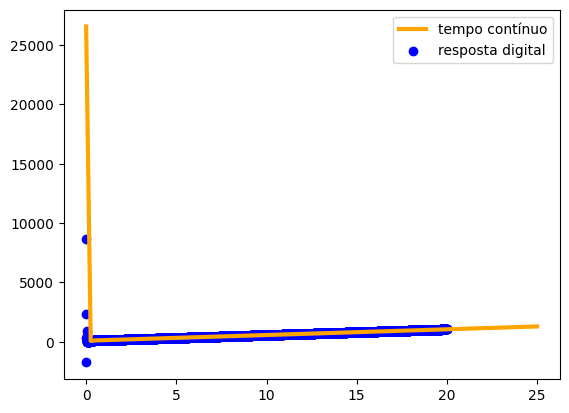

In [66]:
time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

Y_n1 = Y_n2 = Y_n3 = Y_n4 = 0
X_n1 = X_n2 = X_n3 = Y_n4 = 0

time     = np.arange(0, 20, T)
response = [computeController(1, 2) for i in time] # degrau (erro 1 é a entrada)
plt.scatter(time, response, color='blue', label='resposta digital')

plt.legend()
plt.show()

# TESTANDO A RESPOSTA
- Se o erro é positivo, o controlador atua aumentando a saída do sistema

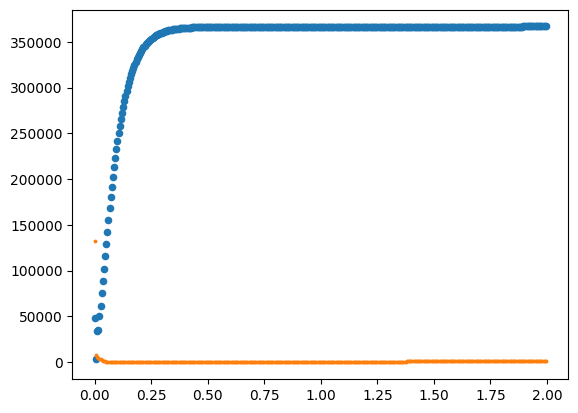

In [67]:
inputValue = 5
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response, s=20)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)

- Se o erro é negativo, o controlador atua diminuindo a saída do sistema

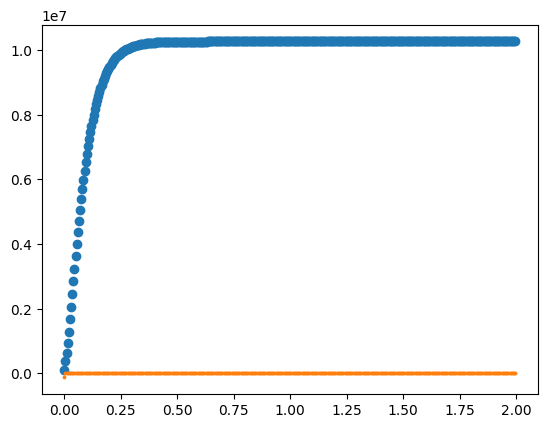

In [68]:
inputValue = 15
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)

- Se o erro é zero, o não atua e mantém a saída fixa

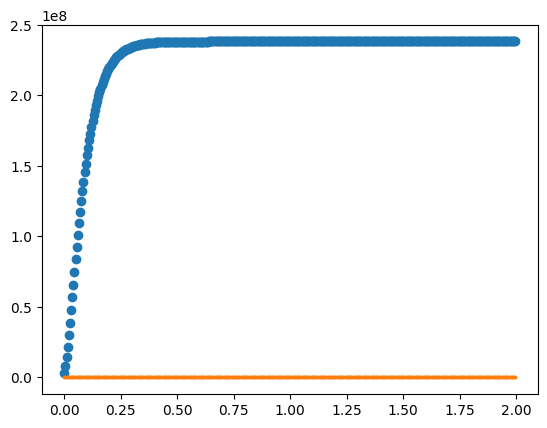

In [69]:
inputValue = 10
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)